# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


# Performing Sharpe Style Analysis

The key to obtaining the weights is our old friend, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

The code to implement this is a very slight modification of the `minimize_vol` we have previously implemented:

```python                         
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights
```

The Objective function is a very simple one-liner

```python
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))
```

In [176]:
import numpy as np
import pandas as pd

import edhec_risk_kit_202 as erk

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
ind = erk.get_ind_returns()["2000":]

Let's construct a manager that invests in 30% Beer, 50% in Smoke and 20% in other things that have an average return of 0% and an annualized vol of 15%

In [178]:
mgr_r = 0.3*ind["Beer"] + .5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

Now, assume we knew absolutely nothing about this manager and all we observed was the returns. How could we tell what she was invested in?

In [179]:
weights = erk.style_analysis(mgr_r, ind)*100

<AxesSubplot:>

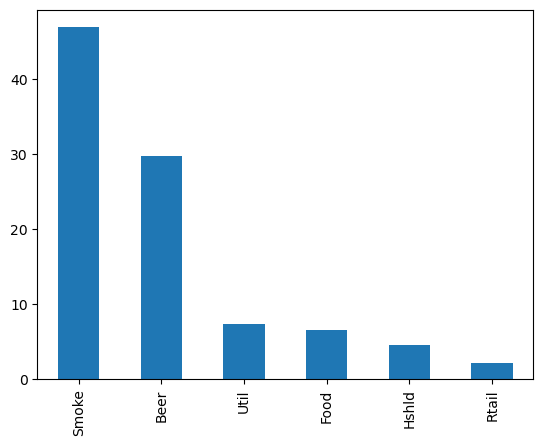

In [180]:
weights.sort_values(ascending=False).head(6).plot.bar()

Contrast this to the results of a regression. Because the model is in fact very true (i.e. we really did construct the manager's returns out of the building blocks), the results are remarkably accurate. However, the negative coefficients are hard to intepret and in real-life data, those will be much larger. However when it works well, such as in this artificial example here, the results can be very accurate.

In [181]:
coeffs = erk.regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Chems   -2.596498
BusEq   -2.178753
Books   -2.113172
Games   -1.801338
Hshld   -1.750412
dtype: float64

Negative 3.5% in Utilities?

<AxesSubplot:>

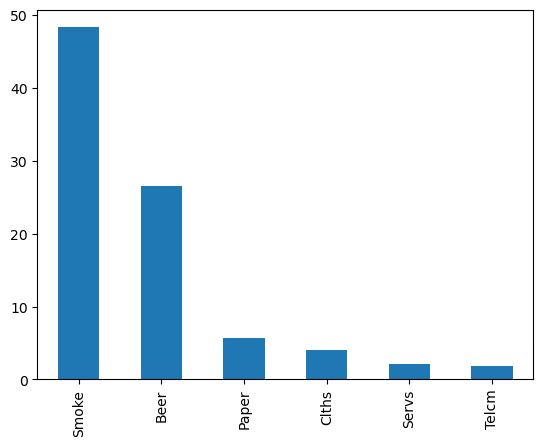

In [182]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

## Style Drift: Time Varying Exposures using Style Anaylsis

One of the most common ways in which Sharpe Style Analysis can be used is to measure style drift. If you run the style analysis function over a rolling window of 1 to 5 years, you can extract changes in the style exposures of a manager.

We'll look at Rolling Windows in the next lab session.

As an exercise to the student, download a set of returns from Yahoo Finance, and try and measure the style drift in your favorite fund manager. Use reliable Value and Growth ETFs such as "SPYG" and "SPYV" along with a SmallCap ETF such as "SLY" and LargeCap ETF such as "OEF".

Alternately, the Fama-French research factors and use the Top and Bottom portfolios by Value (HML) and Size (SMB) to categorize mutual funds into categories. This is very similar to the "Style Box" methodology employed by Morningstar and displayed on their website. Compare your results with their results to see if they agree!

In [291]:
import pandas as pd
import yfinance as yf
data = yf.download(["SPYG", "SPYV", "SLY", "OEF"])["Adj Close"]
# data = yf.download(["SI=F", 'GC=F', 'BTC-USD', 'GBPUSD=X'])["Adj Close"]

[*********************100%***********************]  4 of 4 completed


In [293]:
rets = data.pct_change().dropna()
rets = rets.resample('M').apply(erk.compound).to_period('M')
rets = rets["2006":"2018"]
rets

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,OEF,SLY,SPYG,SPYV
Date,,,,
2006-01,0.017575,0.075884,0.034399,0.028091
2006-02,0.004318,0.010837,-0.015258,0.006657
2006-03,0.017368,0.035951,0.016788,0.014444
2006-04,0.012559,0.005105,-0.001174,0.021991
2006-05,-0.022963,-0.051605,-0.036435,-0.024058
...,...,...,...,...
2018-08,0.038486,0.047606,0.048431,0.013307
2018-09,0.007228,-0.030739,0.007291,0.003851
2018-10,-0.064882,-0.105075,-0.081067,-0.053663


In [294]:
fff_real_ptd = pd.DataFrame({
    "HML": np.array(rets["SPYV"].tolist()) - np.array(rets["SPYG"].tolist()), 
    "SMB": np.array(rets["SLY"].tolist()) - np.array(rets["OEF"].tolist())
}, index = rets.index)
fff_real_ptd

,HML,SMB
Date,,
2006-01,-0.006308,0.058309
2006-02,0.021915,0.006520
2006-03,-0.002343,0.018582
2006-04,0.023165,-0.007455
2006-05,0.012377,-0.028642
...,...,...
2018-08,-0.035124,0.009120
2018-09,-0.003441,-0.037967
2018-10,0.027404,-0.040193


In [296]:
brka_d = pd.read_csv("data/brka_d_ret.csv", parse_dates=True, index_col=0)
brka_m = brka_d.resample('M').apply(erk.compound).to_period('M')
brka = brka_m["2006":"2018"]
brka

,BRKA
DATE,
2006-01,0.009817
2006-02,-0.030059
2006-03,0.040899
2006-04,-0.014942
2006-05,0.036966
...,...
2018-08,0.047256
2018-09,0.013300
2018-10,-0.038422


In [306]:
# regression 
result = erk.regress(brka['BRKA'], fff_real_ptd, alpha=True)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     5.338
Date:                Thu, 02 Feb 2023   Prob (F-statistic):            0.00574
Time:                        02:57:46   Log-Likelihood:                 260.62
No. Observations:                 156   AIC:                            -515.2
Df Residuals:                     153   BIC:                            -506.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HML            0.4930      0.195      2.535      0.012       0.109       0.877
SMB            0.2866      0.129      2.215      0.028       0.031       0.542
Alpha          0.0097      0.004      2.624      0.010       0.002       0.017
==============================================================================
Omnibus:                        2.392   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.949
Skew:                           0.192   Prob(JB):                        0.377
Kurtosis:                       3.391   Cond. No.                         52.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

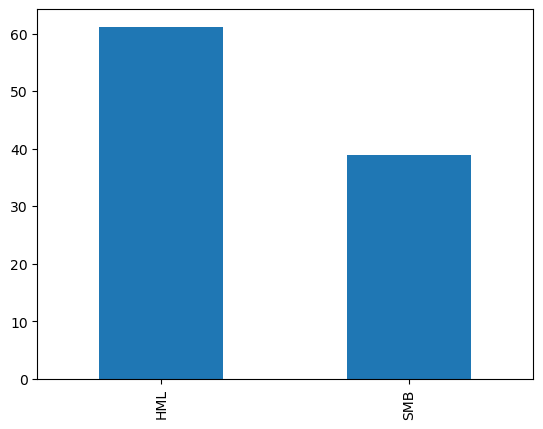

In [307]:
weights = erk.style_analysis(brka['BRKA'], fff_real_ptd)*100
weights.sort_values(ascending=False).head(6).plot.bar()

# Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [8]:
brka_m = pd.read_csv("brka_m.csv", index_col=0, parse_dates=True).to_period('M')

In [9]:
mgr_r_b = brka_m["2000":]["BRKA"]
weights_b = erk.style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

If we want to look at the last decade (2009-2018):

In [10]:
brk2009 = brka_m["2009":]["BRKA"]
ind2009 = ind["2009":]
erk.style_analysis(brk2009, ind2009).sort_values(ascending=False).head(6).round(4)*100

Other    43.64
Food     28.33
Hlth     22.72
Rtail     5.25
Meals     0.07
Books     0.00
dtype: float64

Should you believe the analysis? Probably not. However, when the specification is in fact accurate (as we saw in the articially generated series) the results can be very revealing